In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read data

In [2]:
df = pd.read_csv('data/churn_data_encoded.csv')

In [4]:
df_test = pd.read_csv('data/churn_data.csv')

print(len(df_test))
print(len(df_test.dropna()))

7043
2493


### Prepare evaluation

In [3]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer

# Define own scoring function based on estimated FP and FN costs
def custom_score(y_true, y_pred):
    # Define scores: FP = 1, FN = 5, TP = TN = 0
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total # set score in relation to total number of samples
    return score

def print_scores(scores):
    # Print scores for each fold
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
        })
    print("Scores:\n", scores_df)

    # Print average scores
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)


def evaluate_classification(X, y, classifier):
    # Create custom scorer
    custom_scorer = make_scorer(custom_score, greater_is_better=False)

    # Use cross-validation to evaluate performance
    cv = StratifiedKFold(
        shuffle=True,
        n_splits=5,
        random_state=42
        )

    scores = cross_validate(
        classifier, 
        X, 
        y, 
        cv=cv, scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'custom_score': custom_scorer,
        })
    
    print_scores(scores)
    return scores

### Start: Neural Networks

In [4]:
from sklearn.neural_network import MLPClassifier

# First using all features and default parameters
X = df.drop('Churn', axis=1)
y = df['Churn']

clf = MLPClassifier(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    random_state=42,
)

scores = evaluate_classification(X, y, clf)

# Classifier seems to always predict the same class

c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Scores:
    Fold  Accuracy  Precision  Recall   F1  Custom Score
0     1  0.734752        0.0     0.0  0.0     -1.326241
1     2  0.734752        0.0     0.0  0.0     -1.326241
2     3  0.734752        0.0     0.0  0.0     -1.326241
3     4  0.735795        0.0     0.0  0.0     -1.321023
4     5  0.734375        0.0     0.0  0.0     -1.328125
5     6  0.734375        0.0     0.0  0.0     -1.328125
6     7  0.734375        0.0     0.0  0.0     -1.328125
7     8  0.734375        0.0     0.0  0.0     -1.328125
8     9  0.734375        0.0     0.0  0.0     -1.328125
9    10  0.734375        0.0     0.0  0.0     -1.328125

Statistics:
                    Min     Mean       Max
accuracy      0.734375  0.73463  0.735795
precision          0.0      0.0       0.0
recall             0.0      0.0       0.0
f1                 0.0      0.0       0.0
custom_score -1.328125 -1.32685 -1.321023


In [23]:
# Balance the classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check if classes are balanced
print(y_resampled.value_counts())

Churn
0    5174
1    5174
Name: count, dtype: int64


In [24]:
# Scale features from 0 to 1
# This is important for neural networks (SVM, k-nearest Neigbors) to work properly because the activation functions are sensitive to the input values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [7]:
# Train the classifier again
clf = MLPClassifier(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    random_state=42,
)

scores = evaluate_classification(X_resampled_scaled, y_resampled, clf)

c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.960386   0.964844  0.955513  0.960155     -0.128502
1     2  0.971014   0.969171  0.972921  0.971042     -0.083092
2     3  0.963285   0.954459  0.972921  0.963602     -0.090821
3     4  0.961353   0.959538  0.963250  0.961390     -0.112077
4     5  0.969082   0.961977  0.976834  0.969349     -0.077295
5     6  0.970048   0.965583  0.974903  0.970221     -0.080193
6     7  0.965217   0.970703  0.959459  0.965049     -0.115942
7     8  0.957488   0.955769  0.959459  0.957611     -0.123671
8     9  0.960348   0.954198  0.967118  0.960615     -0.105416
9    10  0.955513   0.957282  0.953578  0.955426     -0.137331

Statistics:
                    Min      Mean       Max
accuracy      0.955513  0.963374  0.971014
precision     0.954198  0.961352  0.970703
recall        0.953578  0.965596  0.976834
f1            0.955426  0.963446  0.971042
custom_score -0.137331 -0.105434 -0.077295


c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Continue: Neural networks

c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marcb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization

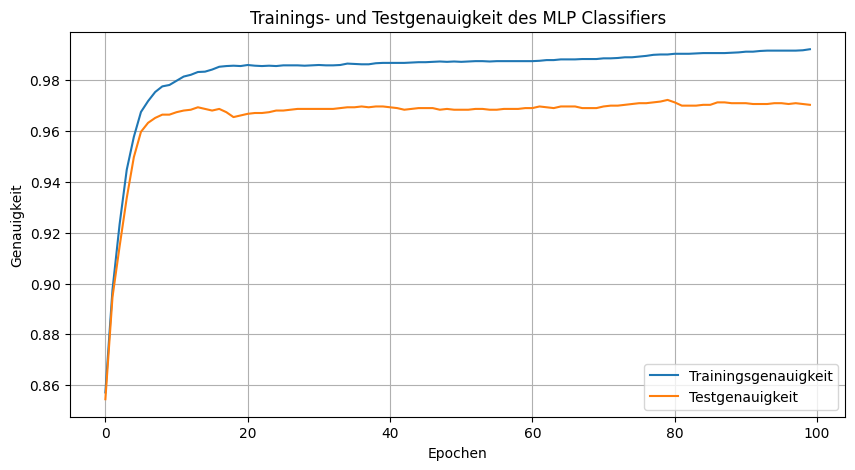

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.3, random_state=42)

mlp = MLPClassifier(
    hidden_layer_sizes=(100,), 
    max_iter=1, 
    warm_start=True, 
    random_state=42)

# Train over multiple epochs
train_acc = []
test_acc = []
for _ in range(100):  # 100 Epochs
    mlp.fit(X_train, y_train)
    
    # Calculate accuracy for training set
    y_pred_train = mlp.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_acc.append(train_accuracy)
    
    # Calculate accuracy for test set
    y_pred_test = mlp.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_acc.append(test_accuracy)

# Visualize results
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Trainingsgenauigkeit')
plt.plot(test_acc, label='Testgenauigkeit')
plt.title('Trainings- und Testgenauigkeit des MLP Classifiers')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Get correlations
correlations = df.corr()
sorted_corrs = correlations['Churn'].abs().sort_values(ascending=False)
sorted_corrs = sorted_corrs.drop('Churn')
print(sorted_corrs)

Satisfaction Score            0.754649
Contract_Month-to-Month       0.448427
Tenure in Months              0.352861
Contract_Two Year             0.328195
Number of Referrals           0.286540
                                ...   
City_Sequoia National Park    0.000830
City_Wasco                    0.000830
City_Visalia                  0.000659
City_Los Angeles              0.000397
City_Ontario                  0.000136
Name: Churn, Length: 1155, dtype: float64


In [18]:
# Add features one by one and evaluate the classifier

selected_features = []
for feature in sorted_corrs.index:

    selected_features.append(feature)
    if len(selected_features) == 1:
        continue
    
    X_temp = X_resampled_scaled[selected_features]
    print("\nSelected features:", selected_features)

    clf = MLPClassifier(
        solver='adam',
        alpha=1e-5,
        hidden_layer_sizes=(5, 2),
        random_state=42,
        max_iter=1000
    )
    scores = evaluate_classification(X_temp, y_resampled, clf)

    if len(selected_features) == 10:
        break


Selected features: ['Satisfaction Score', 'Contract_Month-to-Month']
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.945411        1.0  0.890821  0.942259     -0.272947
1     2  0.941063        1.0  0.882126  0.937372     -0.294686
2     3  0.946377        1.0  0.892754  0.943338     -0.268116
3     4  0.933301        1.0  0.866538  0.928497     -0.333494
4     5  0.945868        1.0  0.891787  0.942799     -0.270662

Statistics:
                    Min      Mean       Max
accuracy      0.933301  0.942404  0.946377
precision          1.0       1.0       1.0
recall        0.866538  0.884805  0.892754
f1            0.928497  0.938853  0.943338
custom_score -0.333494 -0.287981 -0.268116

Selected features: ['Satisfaction Score', 'Contract_Month-to-Month', 'Tenure in Months']
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.945411   1.000000  0.890821  0.942259     -0.272947
1     2  0.946860   0.968592  0.923671  0.9455

### Grid search

In [31]:
from sklearn.model_selection import GridSearchCV

def apply_grid_search(classifier, param_grid, X, y, cv=10, scoring='accuracy'):
    # Use grid search to find best hyperparameters
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)

    # Print best hyperparameters
    print("Best hyperparameters:")
    print(grid_search.best_params_)


In [34]:
# Take first 6 features
selected_features = sorted_corrs[:6].index.to_list()

# Balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X[selected_features], y)

# Scale features from 0 to 1
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)


# Define and execute grid search
param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3],
    'hidden_layer_sizes': [(5, 2), (10, 5), (20, 10)],
    'solver': ['adam', 'sgd'],
}

apply_grid_search(MLPClassifier(max_iter=1000), param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')


Best hyperparameters:
{'alpha': 1e-05, 'hidden_layer_sizes': (20, 10), 'solver': 'adam'}


### Finalize

In [36]:
# Train with best hyperparameters

model = MLPClassifier(
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(20, 10),
    random_state=42,
    max_iter=1000
)

model.fit(X_resampled_scaled, y_resampled)

y_pred = model.predict(X_resampled_scaled)

from sklearn.metrics import classification_report
result = classification_report(y_resampled, y_pred)
print(result)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5174
           1       0.95      0.94      0.94      5174

    accuracy                           0.94     10348
   macro avg       0.94      0.94      0.94     10348
weighted avg       0.94      0.94      0.94     10348



In [42]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_resampled, y_pred)
print(conf_matrix)

conf_matrix_rel = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_rel)

[[4897  277]
 [ 325 4849]]
[[0.94646308 0.05353692]
 [0.06281407 0.93718593]]


In [43]:
# Calculate Cost
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
cost = fp + 5 * fn
print("Cost: ", cost)

Cost:  1902


In [47]:
# Save model
import joblib

joblib.dump(model, 'models/mlp_model.pkl')

['models/mlp_model.pkl']